In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##TO-DO
1. реализовать алгоритм floor count
2. применить алгоритм windows count ко всем картам сегментации ☑
3. применить аугментацию, чтобы повысить качество модели
4. оптимизировать модель
5. deploy

##Get files

###From CipiOrhei/TMBuD

In [1]:
# import pathlib

# if not pathlib.Path('TMBuD').exists():
#     !git clone https://github.com/CipiOrhei/TMBuD.git

# !mv TMBuD/files.txt /content
# !mv TMBuD/DATASET\ SPLIT.csv /content
# !mv TMBuD/gt_label /content
# !mv TMBuD/images /content

# !sed -i 's/import thinning/#import thinning/' TMBuD/parse_database.py
# !python TMBuD/parse_database.py --variant SEMSEG_EVAL_FULL

###From CMP Facade Database

In [ ]:
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

!mkdir /content/CMP_facade
!mkdir /content/CMP_facade_x
!unzip /content/CMP_facade_DB_base.zip -d /content/CMP_facade/
!unzip /content/CMP_facade_DB_extended.zip -d /content/CMP_facade_x/

##Imports

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
!pip install xmltodict
import xmltodict

##Create dataset

In [4]:
#@title Getting files pathes
base_data_path = '/content/CMP_facade/base'
extended_data_path = '/content/CMP_facade_x/extended'

base_image_paths = sorted([os.path.join(base_data_path, img) \
                           for img in os.listdir(base_data_path) \
                           if img.split('.')[-1] == 'jpg'])
base_mask_paths = sorted([os.path.join(base_data_path, mask) \
                          for mask in os.listdir(base_data_path) \
                          if mask.split('.')[-1] == 'png'])
base_annot_paths = sorted([os.path.join(base_data_path, annot) \
                          for annot in os.listdir(base_data_path) \
                          if annot.split('.')[-1] == 'xml'])

extended_image_paths = sorted([os.path.join(extended_data_path, img) \
                               for img in os.listdir(extended_data_path) \
                               if img.split('.')[-1] == 'jpg'])
extended_mask_paths = sorted([os.path.join(extended_data_path, mask) \
                              for mask in os.listdir(extended_data_path) \
                              if mask.split('.')[-1] == 'png'])
extended_annot_paths = sorted([os.path.join(extended_data_path, annot) \
                              for annot in os.listdir(extended_data_path) \
                              if annot.split('.')[-1] == 'xml'])

print(f'Base images - {len(base_image_paths)}, base masks - {len(base_mask_paths)}')
print(f'Extended images - {len(extended_image_paths)}, extended masks - {len(extended_mask_paths)}')

all_image_paths = base_image_paths + extended_image_paths
all_mask_paths = base_mask_paths + extended_mask_paths
all_annot_paths = base_annot_paths + extended_annot_paths

print(f'All images - {len(all_image_paths)}, all masks - {len(all_mask_paths)}')

Base images - 378, base masks - 378
Extended images - 228, extended masks - 228
All images - 606, all masks - 606


In [5]:
#@title Support functions
def imageLoadPreprocess(image_path=None, mask_path=None):
    if image_path is not None:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image.set_shape([None, None, 3])
        resized_image = tf.image.resize(image, (256, 256))
        return resized_image
    if mask_path is not None:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_image(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask.set_shape([None, None, 1])
        resized_mask = tf.image.resize(mask, (256, 256))
        return resized_mask

def showImageMaskPair(image, mask):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image, interpolation='none')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image, interpolation='none')
    plt.imshow(mask, 'jet', interpolation='none', alpha=0.7)
    plt.title('Masked')
    plt.axis('off')
    plt.show()

In [6]:
building_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
building_dataset = building_dataset.map(lambda x: imageLoadPreprocess(image_path=x))

mask_dataset = tf.data.Dataset.from_tensor_slices(all_mask_paths)
mask_dataset = mask_dataset.map(lambda x: imageLoadPreprocess(mask_path=x))

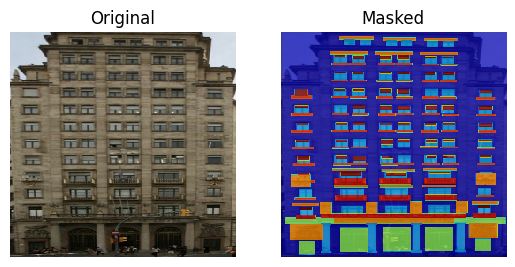

In [7]:
example_b = building_dataset.take(1).get_single_element()
example_m = mask_dataset.take(1).get_single_element()
showImageMaskPair(example_b, example_m)

In [8]:
# @title Dict way to get masks coordinates (slower)
def getObjectPointsFromDict(annot_path, object_name):
    """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
    of object bounding boxes"""
    with open(annot_path) as f:
        xml = f.read()
    xml_dict = xmltodict.parse("<root>" + xml + "</root>")['root']['object']

    object_points = []
    for obj in xml_dict:
        if obj.get('labelname') == object_name:
            x_points = obj.get('points').get('x')
            y_points = obj.get('points').get('y')
            rx_min, rx_max = float(x_points[0]), float(x_points[1])
            ry_min, ry_max = float(y_points[0]), float(y_points[1])
            object_points.append([rx_min, rx_max, ry_min, ry_max])
    return object_points

%time getObjectPointsFromDict(all_annot_paths[0], 'window')
print('Done')

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 22.1 ms
Done


In [9]:
# @title XML ElementTree way to get masks coordinates (faster)
def getObjectPoints(annot_path, object_name):
    """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
    of object bounding boxes"""
    with open(annot_path) as f:
        xml = f.read()
    tree = ET.fromstring("<root>" + xml + "</root>")

    object_points = []
    for obj in tree:
        labelname = obj.find('labelname').text[1:-1]
        points = obj.find('points')
        if labelname == object_name:
            x_points = points.findall('x')
            y_points = points.findall('y')
            rx_min, rx_max = float(x_points[0].text), float(x_points[1].text)
            ry_min, ry_max = float(y_points[0].text), float(y_points[1].text)
            object_points.append([rx_min, rx_max, ry_min, ry_max])
    return object_points

%time getObjectPoints(all_annot_paths[0], 'window')
print('Done')

CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.58 ms
Done


In [10]:
#@title Support functions
def getObjectSegmentMap(obj_coords, image_shape):
    bg = np.zeros(image_shape, dtype=np.float32)
    for obj in obj_coords:
        x_min, x_max = int(obj[0] * bg.shape[0]), int(obj[1] * bg.shape[0])
        y_min, y_max = int(obj[2] * bg.shape[1]), int(obj[3] * bg.shape[1])
        bg[x_min:x_max, y_min:y_max] = 1.0
    bg = tf.constant(bg)
    return bg

def getTotalSegmentMaps(all_object_coords, images_shapes):
    segs_dataset = []
    for i in range(len(all_object_coords)):
        segs = getObjectSegmentMap(all_object_coords[i], images_shapes[i])
        segs_dataset.append(segs)
    return segs_dataset

In [11]:
all_windows_bboxes = [getObjectPoints(annot_path, 'window') for annot_path in all_annot_paths]

img_shapes = [image.shape for image in building_dataset.as_numpy_iterator()]
windows_maps = getTotalSegmentMaps(all_windows_bboxes, img_shapes)

windows_dataset = tf.data.Dataset.from_tensor_slices(windows_maps)
windows_dataset = windows_dataset.map(tf.image.rgb_to_grayscale)

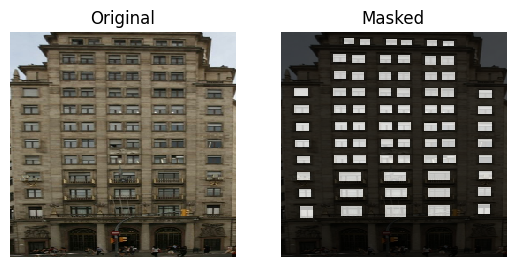

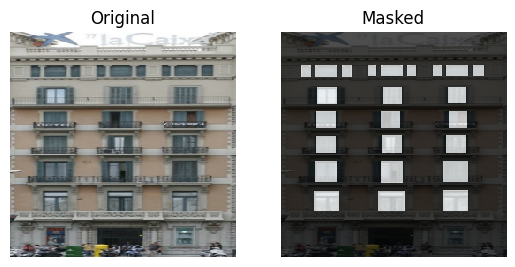

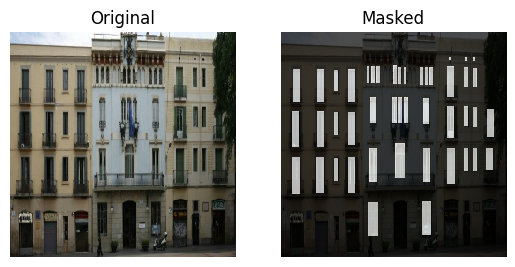

In [13]:
for idx, img in building_dataset.take(3).enumerate():
    showImageMaskPair(img, windows_maps[idx])

In [14]:
dataset = tf.data.Dataset.zip(building_dataset, windows_dataset)

train_size = int(dataset.cardinality().numpy() * 0.8)
train_data = dataset.take(train_size)
test_data = dataset.skip(train_size)

val_size = int(test_data.cardinality().numpy() * 0.8)
val_data = test_data.take(val_size)
test_data = test_data.skip(val_size)

print(f'Train size = {train_data.cardinality().numpy()}')
print(f'Val size = {val_data.cardinality().numpy()}')
print(f'Test size = {test_data.cardinality().numpy()}')

train_data = train_data.batch(16)
val_data = val_data.batch(16)
test_data = test_data.batch(16)

Train size = 484
Val size = 97
Test size = 25


##Create model

In [ ]:
def buildUNetModel():
    x = tf.keras.layers.Input((256, 256, 3))

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out1)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out2)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out3)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out4)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

##Train model

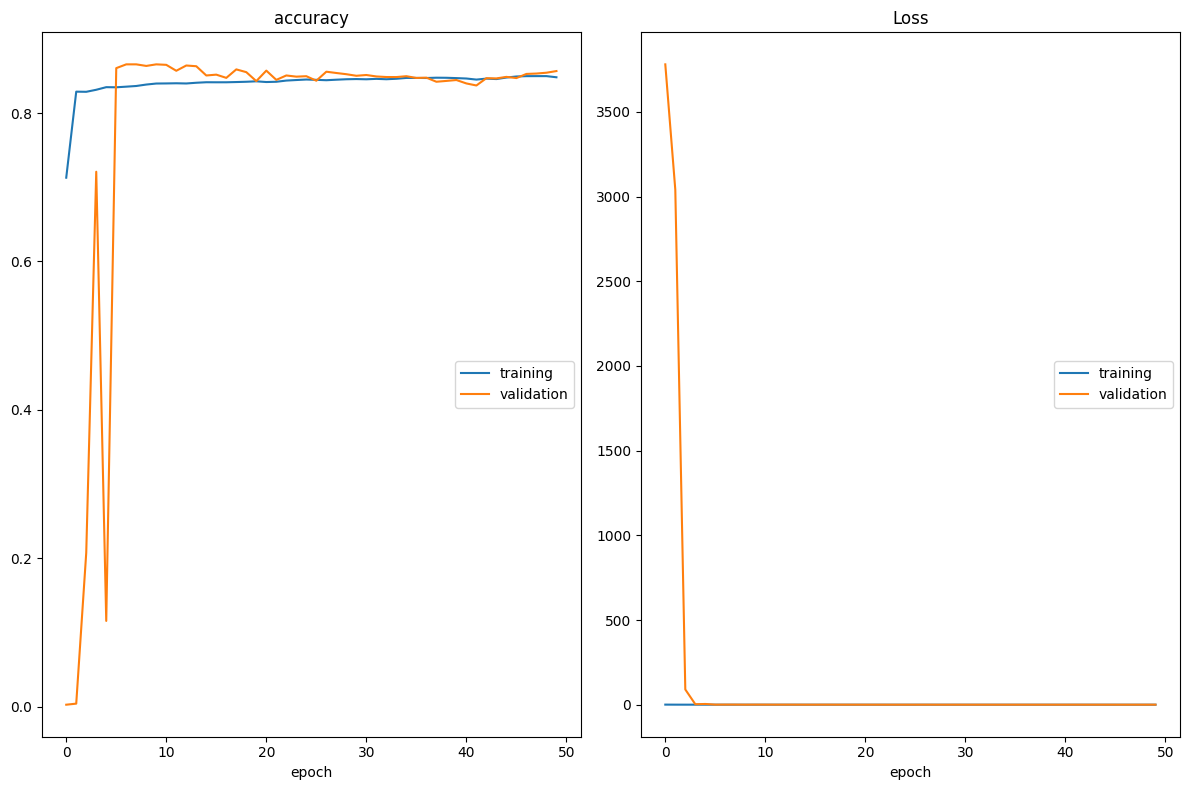

accuracy
	training         	 (min:    0.713, max:    0.850, cur:    0.848)
	validation       	 (min:    0.003, max:    0.866, cur:    0.857)
Loss
	training         	 (min:    0.036, max:    0.558, cur:    0.041)
	validation       	 (min:    0.222, max: 3780.156, cur:    0.301)
31/31 [==============================] - 43s 1s/step - loss: 0.0411 - accuracy: 0.8482 - val_loss: 0.3012 - val_accuracy: 0.8566


In [ ]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
EPOCHS = 50

model = buildUNetModel()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=EPOCHS,
                 callbacks=[PlotLossesCallback()]
                 )

model.save(model_path)

In [ ]:
model.evaluate(test_data)

2/2 [==============================] - 8s 5s/step - loss: 0.4693 - accuracy: 0.8450


[0.4692530035972595, 0.8450097441673279]

##Load model

In [15]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
model = tf.keras.saving.load_model(model_path)

##Get segmentation

In [16]:
#@title Support functions
def getSomePredictions(data, n=3):
    data = (data
            .unbatch()
            .shuffle(50)
            .take(n)
            .as_numpy_iterator())

    for img, label in data:
        pred = model.predict(img[None, ...])
        seg_map = (pred[0] > 0.5).astype(np.float32)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(img, interpolation='none')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(img, interpolation='none')
        plt.imshow(label, 'jet', interpolation='none', alpha=0.7)
        plt.title('Ground truth')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(img, interpolation='none')
        plt.imshow(seg_map, 'jet', interpolation='none', alpha=0.7)
        plt.title('Masked')
        plt.axis('off')
        plt.show()

In [17]:
test_imgs = test_data.map(lambda x, y: x)
preds = model.predict(test_imgs)

2/2 [==============================] - 27s 5s/step


1/1 [==============================] - 1s 1s/step


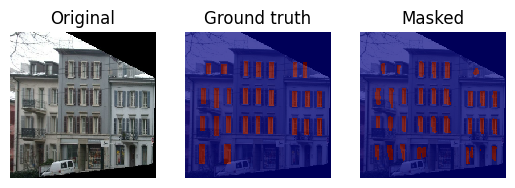

1/1 [==============================] - 0s 32ms/step


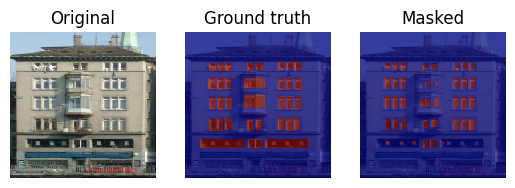

1/1 [==============================] - 0s 22ms/step


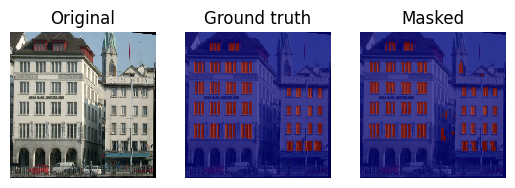

1/1 [==============================] - 0s 21ms/step


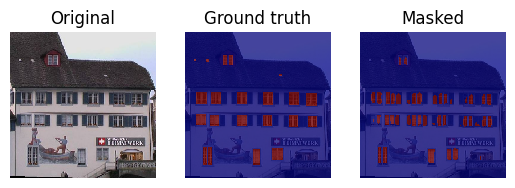

1/1 [==============================] - 0s 20ms/step


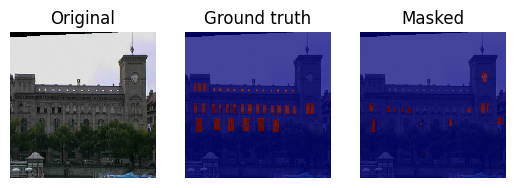

In [18]:
getSomePredictions(test_data, n=5)

##Floors count

Имея карту сегментации (а это массив значений 0 или 1 (окно/не окно) размера 256х256х1) можно элементарно получить проекцию значений на ось Y (вертикаль) с помощью метода `np.sum()`, и по ненулевым значениям можно подсчитать количество рядов окон. Это нам дает ***количество этажей*** (добавить 1 т.к. не всегда на первом этаже фасада здания есть окна)

Осталось только закончить реализацию

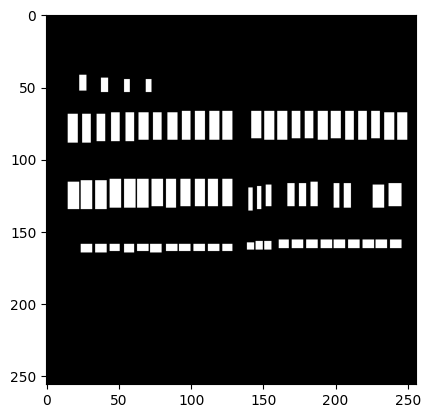

In [19]:
plt.imshow(windows_maps[-1])

In [27]:
projections = np.array([np.array(windows_map).sum(axis=1) for windows_map in windows_maps])[:,:,0]
projections.shape

(606, 256)

In [21]:
# projections = projections.reshape((25,-1))
# projections.shape

(25, 256)

Пики графиков соответствуют рядам окон (интуиция - этажам)

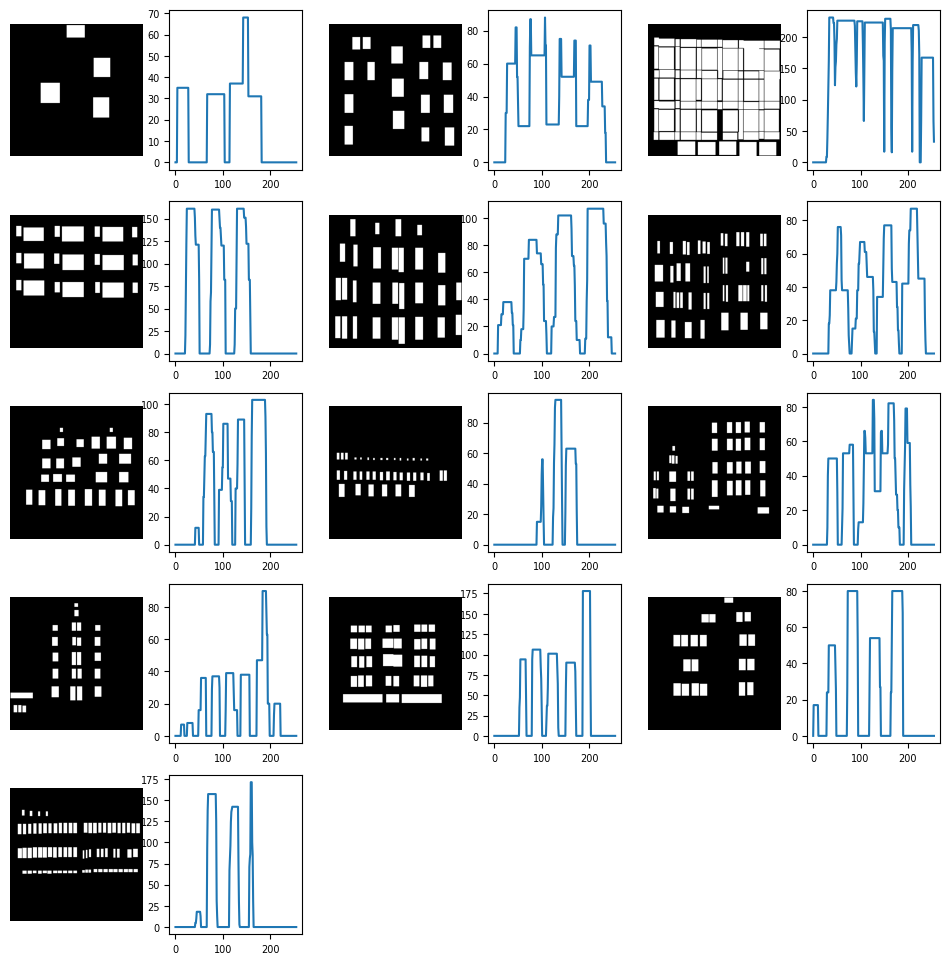

In [28]:
rows, cols = 5, 6
fig = plt.figure(figsize=(12,12))
for i in range(0, 25, 2):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(windows_maps[-25+i])
    plt.axis('off')
    fig.add_subplot(rows, cols, i+2)
    plt.plot(projections[-25+i])
    plt.tick_params(axis='both', which='major', labelsize=7)
plt.show()

##Windows count

Для каждой предсказанной карты сегментации ищем контуры с помощью `cv2.findContours()` выводим длину массива контуров для каждой карты - это и будет ***количество окон***.

In [67]:
# @title Support Function
def compareWindowsNumber(pred_contours, orig_contours):
    num_pred_windows, num_orig_windows = len(pred_contours), len(orig_contours)

    plt.rc('axes', titlesize= 9)
    fig = plt.figure(figsize=(6,6))
    fig.add_subplot(1, 2, 1)
    title_obj = plt.title(f'Number of predicted windows: {num_pred_windows}')
    if num_pred_windows != num_orig_windows:
        plt.setp(title_obj, color='r')
    plt.axis('off')
    plt.imshow(pred_map)

    fig.add_subplot(1, 2, 2)
    plt.title(f'Number of original windows: {num_orig_windows}')
    plt.axis('off')
    plt.imshow(windows_maps[-25+idx])
    plt.show()

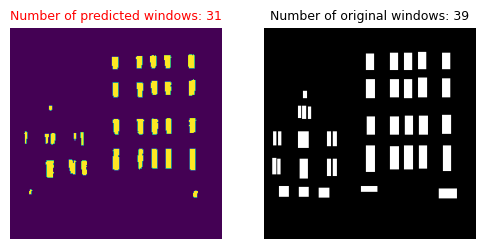

In [178]:
idx = 16
treshold = 0.9

pred_map = (preds[idx] > treshold).astype(np.uint8)
orig_map = windows_maps[-25+idx].numpy()[:,:,0].astype(np.uint8)

pred_contours, _ = cv2.findContours(pred_map, method=cv2.RETR_EXTERNAL, mode=cv2.CHAIN_APPROX_NONE)
orig_contours, _ = cv2.findContours(orig_map, method=cv2.RETR_EXTERNAL, mode=cv2.CHAIN_APPROX_NONE)

compareWindowsNumber(pred_contours, orig_contours)

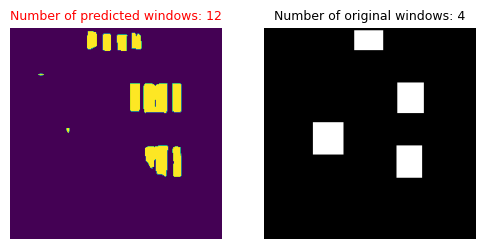

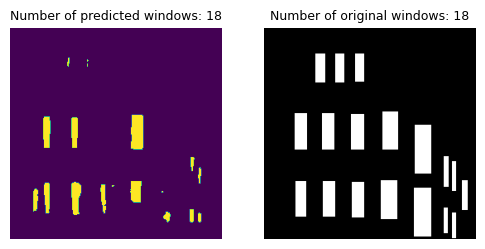

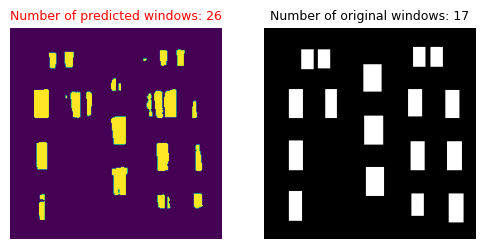

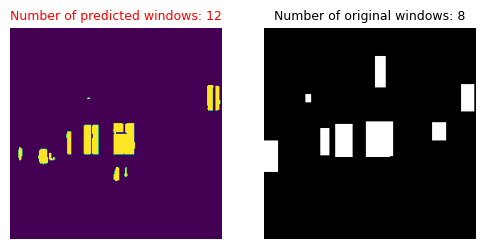

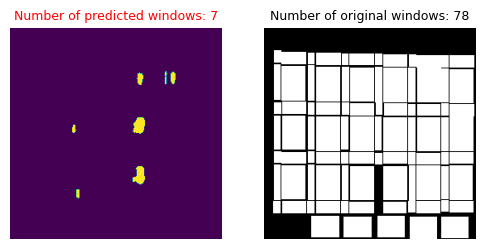

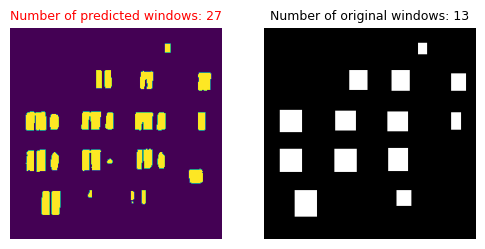

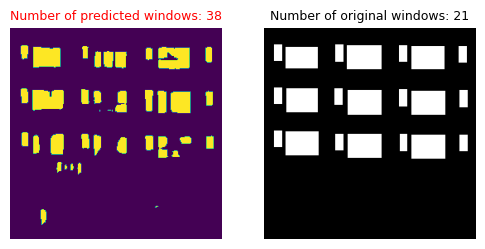

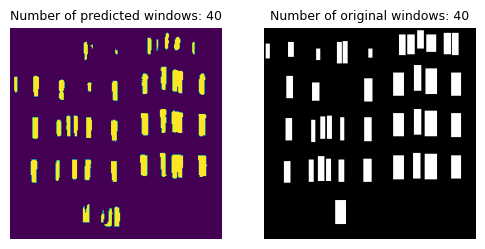

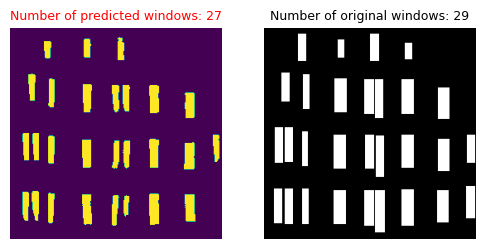

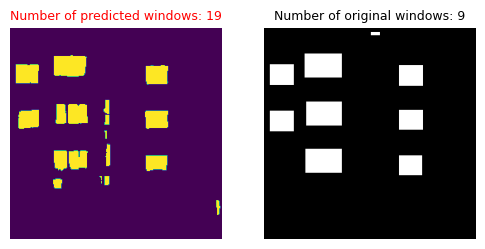

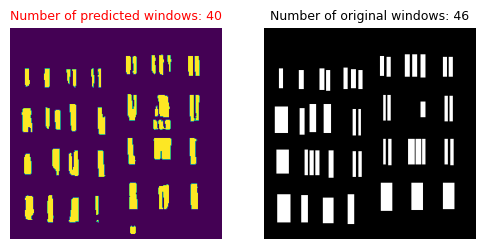

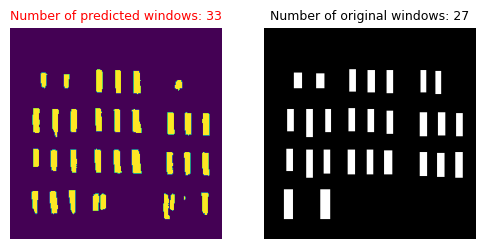

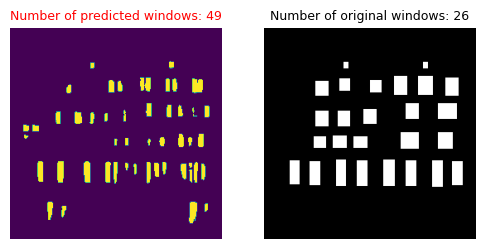

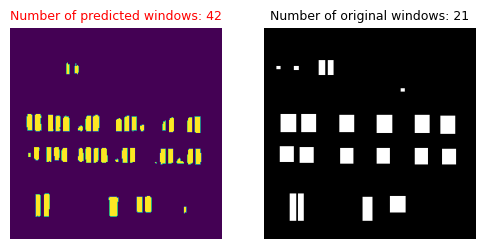

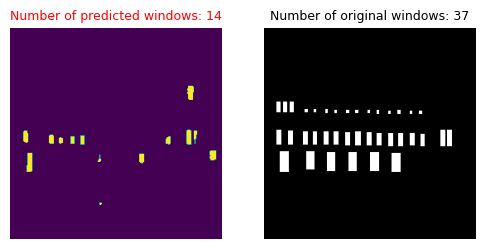

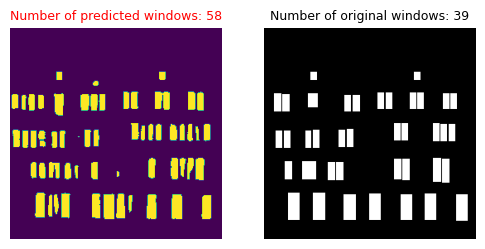

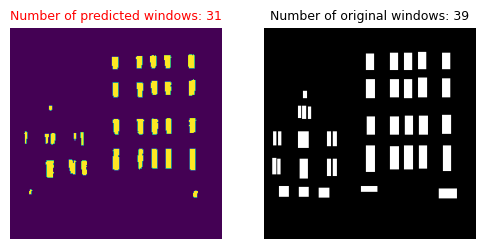

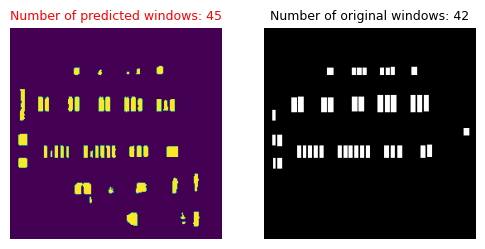

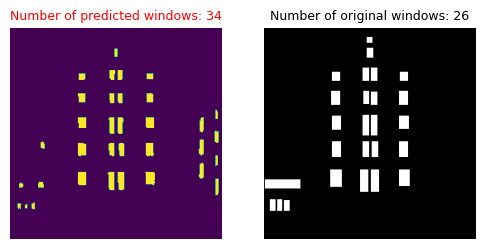

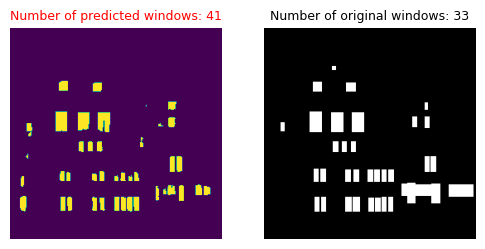

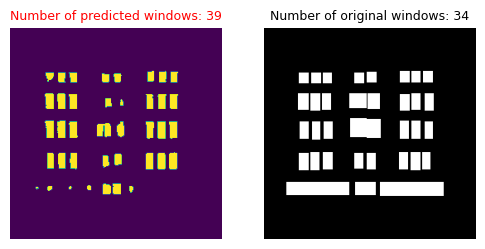

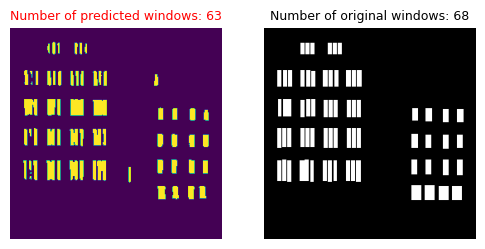

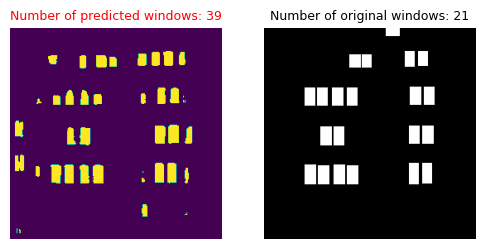

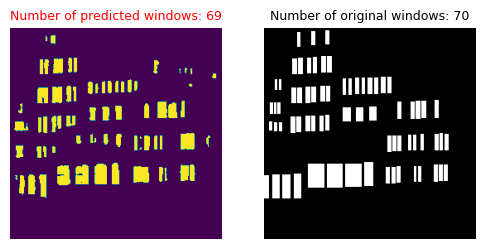

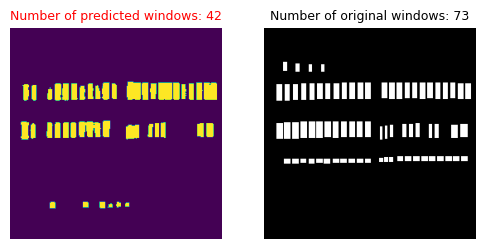

In [190]:
for idx in range(25):
    try:
        treshold = 0.5
        pred_map = (preds[idx] > treshold).astype(np.uint8)
        pred_contours, _ = cv2.findContours(pred_map, method=cv2.RETR_EXTERNAL, mode=cv2.CHAIN_APPROX_NONE)
    except Exception:
        treshold = 0.9
        pred_map = (preds[idx] > treshold).astype(np.uint8)
        pred_contours, _ = cv2.findContours(pred_map, method=cv2.RETR_EXTERNAL, mode=cv2.CHAIN_APPROX_NONE)

    orig_map = windows_maps[-25+idx].numpy()[:,:,0].astype(np.uint8)
    orig_contours, _ = cv2.findContours(orig_map, method=cv2.RETR_EXTERNAL, mode=cv2.CHAIN_APPROX_NONE)

    compareWindowsNumber(pred_contours, orig_contours)

Проблемы:


1.   `cv2.findContours` находит "нулевые" контуры, изза чего возникает ошибка:
`error: OpenCV(4.8.0) /io/opencv/modules/core/src/datastructs.cpp:551: error: (-27:Null pointer)  in function 'cvCvtSeqToArray'`
2.   Неверно предсказанное количество окон








Решение:
1.   Увеличить порог предсказания модели (с 0.5 до 0.9)
2.   Повысить качество сегментационной модели, так чтобы на картах сегментации отсутствовали ложные сегменты ("нулевые" контуры)
3.   Использовать модель детектирования окон, а не сегментации

